# Cascadia Margin Modeling

In [1]:
from os.path import join
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import ternary

In [3]:
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## configuration

In [4]:
from matplotlib import style

In [5]:
style.use(join("..", "style.mplstyle"))
datadir = join("..", "data", "processed")

## load data

### relative abundance and d13c of GDGT compounds

In [6]:
df = pd.read_excel(join(datadir, "CascadiaMargin_carbon_abundance.xlsx"))
df.replace(
    {"Astoria Cyn": "Astoria Canyon", "Mcarthur cyn": "Mcarthur Canyon"}, inplace=True
)
df.insert(5, "depth_start", df["depth_int"].str.extract(r"(\d)-\d").astype(int))
df.insert(6, "depth_end", df["depth_int"].str.extract(r"\d-(\d)").astype(int))
df.insert(7, "depth_mean", df["depth_start"] / 2 + df["depth_end"] / 2)
df.head(3)

Sample Name        Location Compound  m_from_plume depth_int  depth_start  \
0          S1  Astoria Canyon     Cren            20       0-1            0   
1          S1  Astoria Canyon       G0            20       0-1            0   
2          S1  Astoria Canyon       G1            20       0-1            0   

   depth_end  depth_mean  avg_ugC  F2/F1   d13c_avg  stdev  purity_score  \
0          1         0.5     2.15    9.88    -22.73   0.24          0.85   
1          1         0.5     1.56   12.83    -30.91   0.10          0.95   
2          1         0.5      NaN     NaN       NaN    NaN           NaN   

   rel_abund  
0   0.310392  
1   0.394754  
2   0.099080

## initial plots

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.swarmplot(
    data=df,
    x="Location",
    y="rel_abund",
    hue="Compound",
    dodge=True,
    linewidth=0.5,
    ax=ax,
)
ax.set_xlabel(None)
ax.set_ylabel("Relative Abundance")
ax.grid(True)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.swarmplot(
    data=df,
    x="Location",
    y="d13c_avg",
    hue="Compound",
    dodge=True,
    linewidth=0.5,
    ax=ax,
)
ax.set_xlabel(None)
ax.set_ylabel("$\delta^{13}$C")
ax.grid(True)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.swarmplot(
    data=df,
    x="m_from_plume",
    y="rel_abund",
    hue="Compound",
    dodge=True,
    linewidth=0.5,
    ax=ax,
)
ax.set_xlabel("distance from plume [m]")
ax.set_ylabel("Relative Abundance")
ax.grid(True)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.swarmplot(
    data=df,
    x="m_from_plume",
    y="d13c_avg",
    hue="Compound",
    dodge=True,
    linewidth=0.5,
    ax=ax,
)
ax.set_xlabel("distance from plume [m]")
ax.set_ylabel("$\delta^{13}$C")
ax.grid(True)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True)
for i, (k, g) in enumerate(df.groupby("Location")):
    sns.scatterplot(
        data=g,
        x="rel_abund",
        y="d13c_avg",
        hue="Compound",
        linewidth=0.5,
        ec="k",
        ax=axs[i],
    )
    axs[i].set_title(k)
    axs[i].set_xlabel("Relative Abundance")
    axs[i].set_ylabel("$\delta^{13}$C")
    box = axs[i].get_position()
    axs[i].set_position([box.x0, box.y0, box.width * 0.8, box.height])
    axs[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()

## Modeling

### data setup

unified table

In [7]:
data = df[["Sample Name", "Location", "Compound", "d13c_avg", "rel_abund"]]
data = data.pivot(columns="Compound", index=["Location", "Sample Name"])
data.head()

d13c_avg                                         \
Compound                       Cren Cren regio     G0     G1     G2     G3   
Location       Sample Name                                                   
Astoria Canyon S1            -22.73        NaN -30.91    NaN -83.71    NaN   
               S10           -31.55        NaN -35.05 -78.34 -91.61    NaN   
               S11           -36.44        NaN -36.78 -84.06 -96.46 -94.52   
               S3               NaN        NaN    NaN    NaN    NaN    NaN   
               S4            -23.87        NaN -48.29    NaN -85.14    NaN   

                           rel_abund                                           \
Compound                        Cren Cren regio        G0        G1        G2   
Location       Sample Name                                                      
Astoria Canyon S1           0.310392   0.006300  0.394754  0.099080  0.159489   
               S10          0.206771   0.003419  0.296081  0.118101  0.293912   
               S11          0.169443   0.002705  0.281303  0.130807  0.316319   
               S3           0.289064   0.004071  0.429759  0.138153  0.119159   
               S4           0.220597   0.003209  0.483120  0.112610  0.159364   

                                      
Compound                          G3  
Location       Sample Name            
Astoria Canyon S1           0.029985  
               S10          0.081714  
               S11          0.099422  
               S3           0.019795  
               S4           0.021100

relative abundance table

In [8]:
relative_abundance = data["rel_abund"]
relative_abundance.sample(5)

Compound                         Cren  Cren regio        G0        G1  \
Location        Sample Name                                             
Astoria Canyon  S3           0.289064    0.004071  0.429759  0.138153   
Hydrate Ridge   S47          0.384481    0.020339  0.422302  0.097900   
Mcarthur Canyon S105         0.413780    0.012353  0.466179  0.068064   
Astoria Canyon  S1           0.310392    0.006300  0.394754  0.099080   
Hydrate Ridge   S39          0.366986    0.011387  0.440892  0.074367   

Compound                           G2        G3  
Location        Sample Name                      
Astoria Canyon  S3           0.119159  0.019795  
Hydrate Ridge   S47          0.071148  0.003830  
Mcarthur Canyon S105         0.035446  0.004179  
Astoria Canyon  S1           0.159489  0.029985  
Hydrate Ridge   S39          0.098893  0.007477

In [9]:
relative_abundance.groupby(level=0).agg(["mean", "std"])

Compound             Cren           Cren regio                  G0            \
                     mean       std       mean       std      mean       std   
Location                                                                       
Astoria Canyon   0.232671  0.061758   0.003849  0.001261  0.384482  0.074702   
Hydrate Ridge    0.347357  0.054261   0.027658  0.014274  0.446012  0.027190   
Mcarthur Canyon  0.416745  0.014452   0.011951  0.001285  0.457156  0.015121   

Compound               G1                  G2                  G3            
                     mean       std      mean       std      mean       std  
Location                                                                     
Astoria Canyon   0.120977  0.020703  0.209257  0.076776  0.048763  0.031221  
Hydrate Ridge    0.087233  0.022642  0.084521  0.048481  0.007219  0.005431  
Mcarthur Canyon  0.068468  0.004363  0.040965  0.005039  0.004714  0.000732

carbon isotopic fractionation table

In [10]:
d13C = data["d13c_avg"]
d13C.sample(5)

Compound                         Cren  Cren regio         G0         G1  \
Location       Sample Name                                                
Hydrate Ridge  S65         -19.628772         NaN -21.745757 -38.041319   
Astoria Canyon S9          -28.980000         NaN -34.270000        NaN   
               S11         -36.440000         NaN -36.780000 -84.060000   
               S1          -22.730000         NaN -30.910000        NaN   
Hydrate Ridge  S46         -19.668410         NaN -24.345985 -42.140914   

Compound                           G2     G3  
Location       Sample Name                    
Hydrate Ridge  S65         -58.742436    NaN  
Astoria Canyon S9          -92.520000 -89.81  
               S11         -96.460000 -94.52  
               S1          -83.710000    NaN  
Hydrate Ridge  S46         -64.825093    NaN

In [11]:
d13C.groupby(level=0).agg(["mean", "std"])

Compound              Cren           Cren regio             G0             \
                      mean       std       mean std       mean        std   
Location                                                                    
Astoria Canyon  -27.500000  5.117011        NaN NaN -39.252857  12.583389   
Hydrate Ridge   -20.112818  1.751414        NaN NaN -25.830361  10.365047   
Mcarthur Canyon -18.932976  0.142577        NaN NaN -19.950270   0.922222   

Compound                G1                    G2                 G3            
                      mean        std       mean        std    mean       std  
Location                                                                       
Astoria Canyon  -78.583333   5.359145 -89.108571   5.778086 -92.165  3.330473  
Hydrate Ridge   -46.454807  15.803619 -68.493641  15.006748     NaN       NaN  
Mcarthur Canyon -22.907023   5.434851 -28.755275  13.681861     NaN       NaN

In [12]:
d13C.groupby(level=0).apply(lambda sl: sl.notnull().sum() / len(sl))

Compound          Cren  Cren regio     G0        G1        G2    G3
Location                                                           
Astoria Canyon   0.875         0.0  0.875  0.375000  0.875000  0.25
Hydrate Ridge    1.000         0.0  1.000  1.000000  1.000000  0.00
Mcarthur Canyon  1.000         0.0  1.000  0.230769  0.230769  0.00

the order of the compounds and the lengths of different dimensions

In [13]:
GDGTs = ["G0", "G1", "G2", "G3", "Cren", "Cren regio"]
nchem = len(GDGTs)
communities = ["planktonic/autotrophic", "methanotrophic", "benthic"]
ncom = len(communities)
locations = data.index.levels[0]
nloc = len(locations)
locations

Index(['Astoria Canyon', 'Hydrate Ridge', 'Mcarthur Canyon'], dtype='object', name='Location')

ranges for the proportions of the compounds produced by each community, which go into the priors for `X`

In [14]:
X_lo = np.array(
    [
        [0.2, 0.0, 0.0, 0.0, 0.2, 0.0],
        [0.2, 0.05, 0.2, 0.05, 0.0, 0.0],
        [0.1, 0.0, 0.0, 0.0, 0.0, 0.0],
    ]
)
X_hi = np.array(
    [
        [0.8, 0.2, 0.1, 0.05, 0.5, 0.05],
        [0.5, 0.2, 0.5, 0.2, 1e-2, 1e-2],
        [0.5, 0.3, 0.3, 0.3, 1e-2, 0.1],
    ]
)

ranges for the dC13 values produced by each community, informing the priors for `D`

In [15]:
D_lo = np.array([-22, -120, -34])
D_hi = np.array([-18, -40, -24])

### model definition

In [16]:
with pm.Model() as model:

    # compositional priors for the contributions of different microbial communities
    F = pm.Dirichlet("F", a=np.full(ncom, 1.0), shape=(nloc, ncom))

    # production compositional priors for each compound in each community
    X_ = pm.Beta("X*", mu=(X_hi + X_lo) / 2, sigma=(X_hi - X_lo) / 4)
    # rows must be normalized (sum to 1)
    X = pm.Deterministic("X", X_ / pm.math.sum(X_, axis=1, keepdims=True))

    # relative abundance, given F and X
    M = pm.Deterministic("M", pm.math.dot(F, X))

    pm.Deterministic(
        "Methane Index",
        pm.math.sum(M[:, 1:4], axis=1, keepdims=True)
        / pm.math.sum(M[:, 1:], axis=1, keepdims=True),
    )

    # variance parameters for relative abundances
    sigma_abundance = pm.Beta("sigma abundance", alpha=1, beta=20, shape=(nloc, nchem))

    # relative abundance likelihood
    for i, location in enumerate(locations):
        pm.TruncatedNormal(
            f"{location}\nobserved\nabundance",
            mu=M[i, :],
            sigma=sigma_abundance[i, :],
            observed=relative_abundance[GDGTs].loc[location].values,
            lower=0,
            upper=1,
        )

    # delta C 13 end members
    D = pm.Normal("D", mu=(D_hi + D_lo) / 2, sigma=(D_hi - D_lo) / 4)

    C = pm.Deterministic("C", pm.math.dot(F * D, X) / M)

    sigma_d13c = pm.Exponential("sigma d13C", scale=25, shape=(nloc, nchem))

    for i, location in enumerate(locations):
        for j, compound in enumerate(GDGTs):
            d = d13C[compound].loc[location].dropna().values
            if len(d) > 0:
                pm.Normal(
                    f"{location}\nobserved\n{compound} d13C",
                    mu=C[i, j],
                    sigma=sigma_d13c[i, j],
                    observed=d,
                )

In [ ]:
# pm.model_to_graphviz(model)

### prior predictive checks

In [17]:
with model:
    prior = pm.sample_prior_predictive(samples=16_000)
prior.prior.to_netcdf("../model-results/prior.nc")

Sampling: [Astoria Canyon
observed
Cren d13C, Astoria Canyon
observed
G0 d13C, Astoria Canyon
observed
G1 d13C, Astoria Canyon
observed
G2 d13C, Astoria Canyon
observed
G3 d13C, Astoria Canyon
observed
abundance, D, F, Hydrate Ridge
observed
Cren d13C, Hydrate Ridge
observed
G0 d13C, Hydrate Ridge
observed
G1 d13C, Hydrate Ridge
observed
G2 d13C, Hydrate Ridge
observed
abundance, Mcarthur Canyon
observed
Cren d13C, Mcarthur Canyon
observed
G0 d13C, Mcarthur Canyon
observed
G1 d13C, Mcarthur Canyon
observed
G2 d13C, Mcarthur Canyon
observed
abundance, X*, sigma abundance, sigma d13C]


In [ ]:
fig = plt.figure()
az.plot_density(prior.prior, var_names=["F"], hdi_prob=1, grid=(3, 3))
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(3, 6, figsize=(12, 6), sharex=True)
az.plot_density(prior.prior, var_names=["X"], hdi_prob=1, ax=axs)
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(3, 6, figsize=(12, 6), sharex=True)
az.plot_density(prior.prior, var_names=["M"], hdi_prob=1, ax=axs)
fig.tight_layout()

In [ ]:
fig = plt.figure()
az.plot_density(prior.prior, var_names="D", hdi_prob=1)
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(3, 6, figsize=(12, 6), sharex=True)
az.plot_density(prior.prior, var_names=["C"], hdi_prob=1, ax=axs)
fig.tight_layout()

### posterior sampling

In [18]:
with model:
    post = pm.sample(cores=16, chains=16, tune=2_000, draws=8_000, target_accept=0.975)
post.posterior.to_netcdf("../model-results/posterior.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [F, X*, sigma abundance, D, sigma d13C]


Sampling 16 chains for 2_000 tune and 8_000 draw iterations (32_000 + 128_000 draws total) took 631 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


### checks

<Figure size 960x720 with 0 Axes>

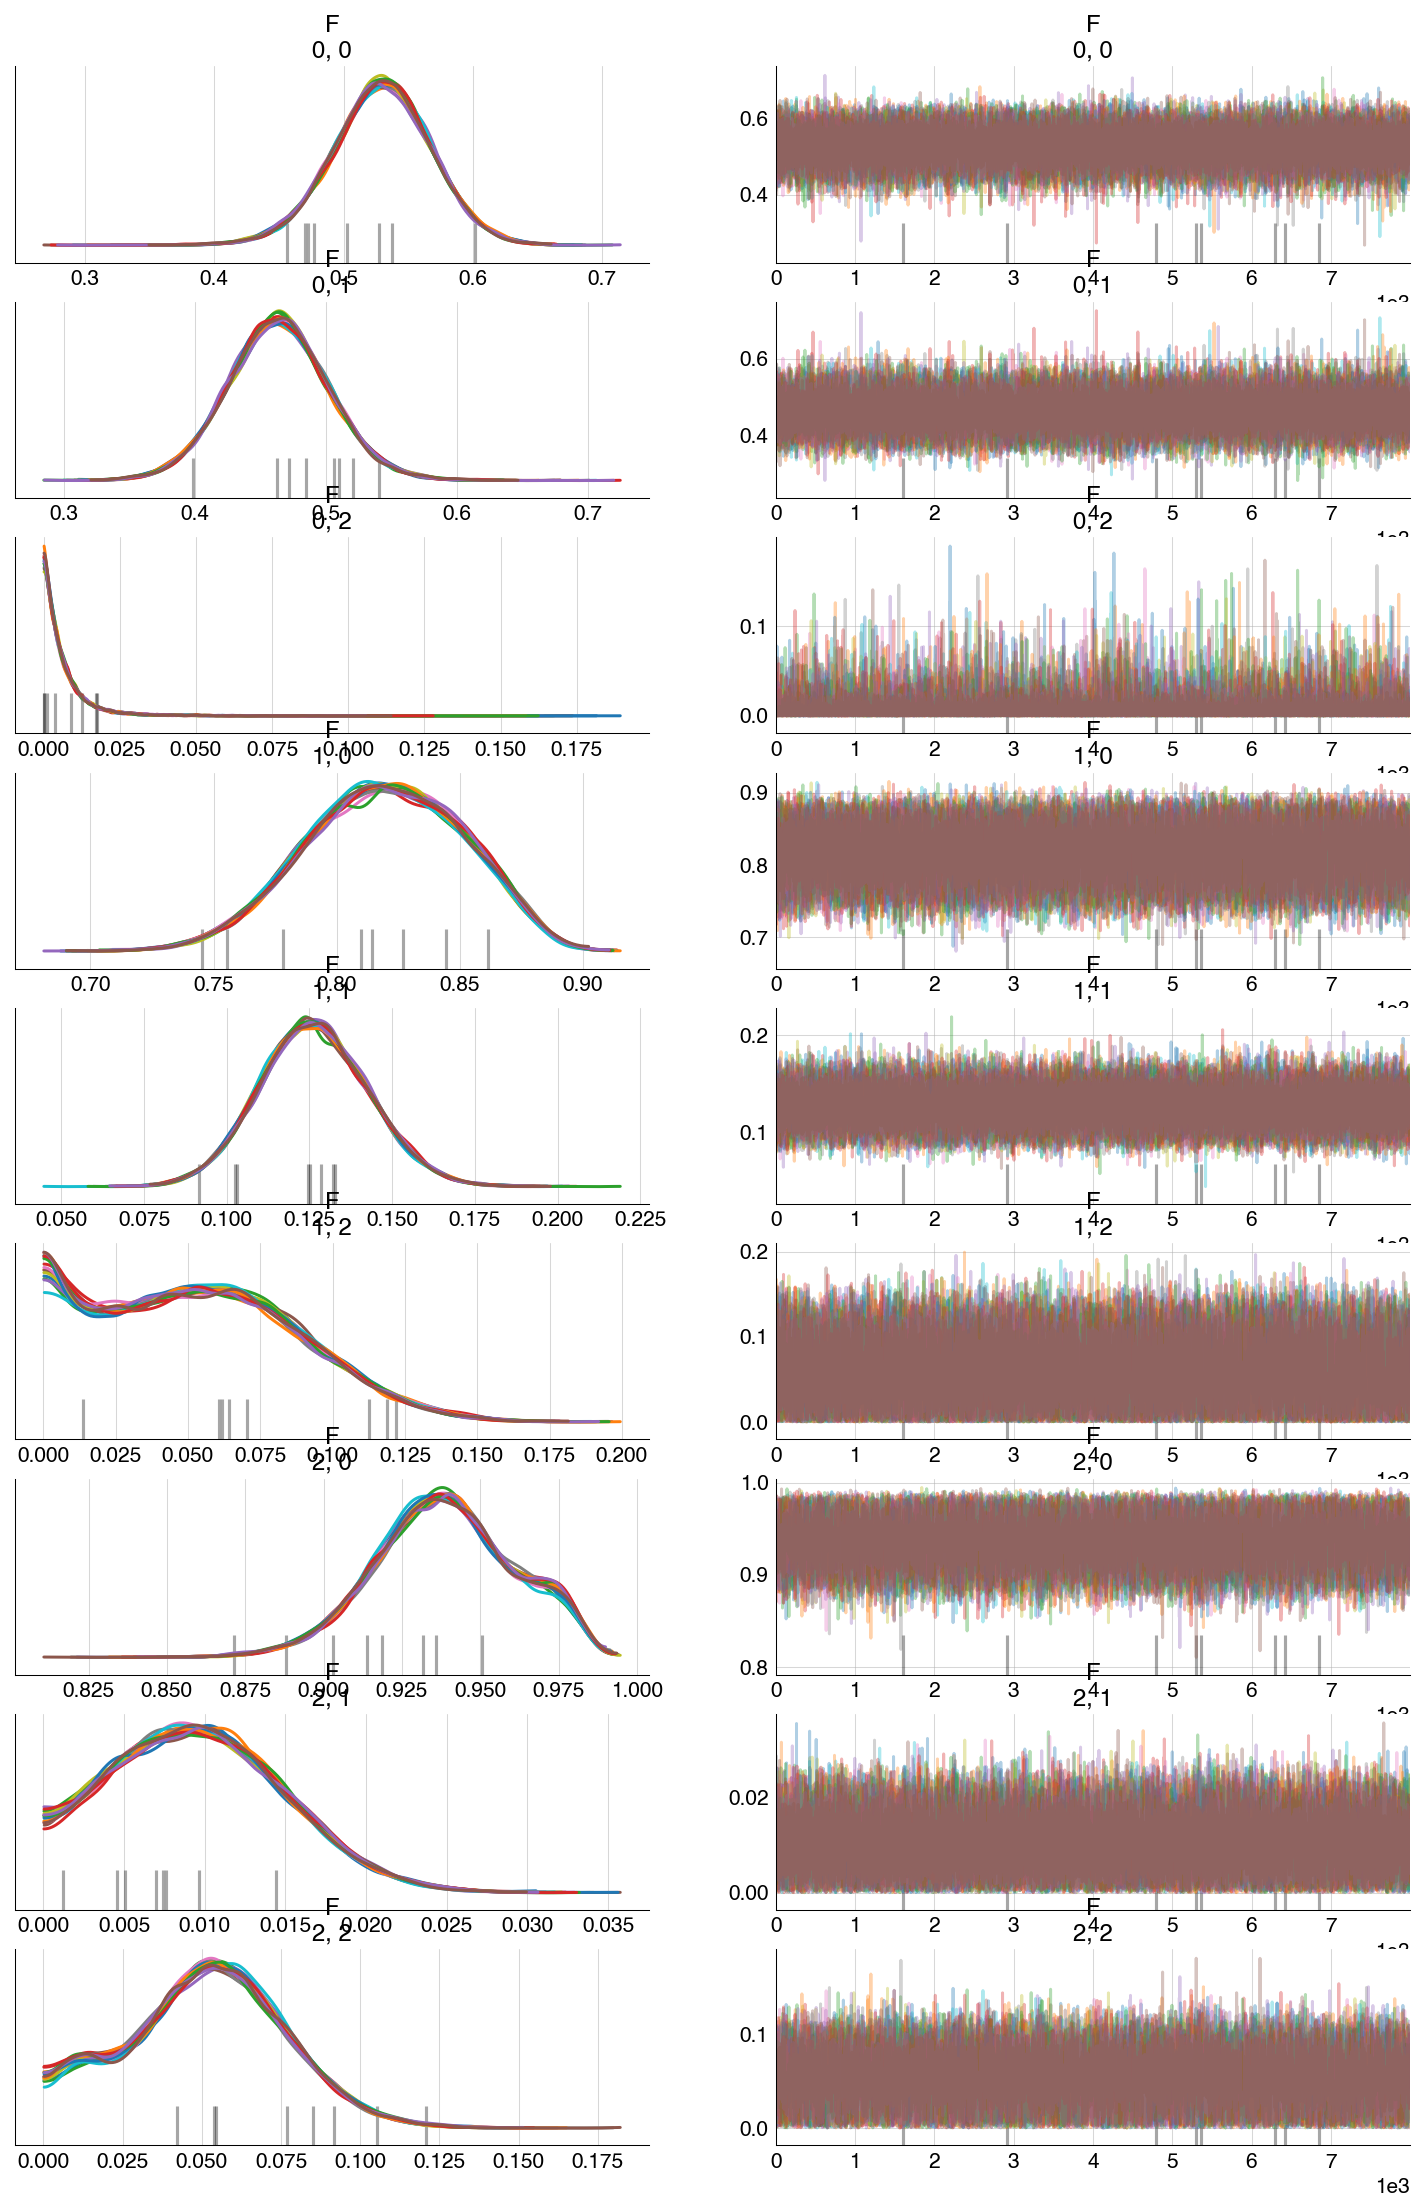

In [19]:
fig = plt.figure()
az.plot_trace(post, var_names=["F"], compact=False)
fig.tight_layout()

In [20]:
with model:
    ppc = pm.sample_posterior_predictive(post)

Sampling: [Astoria Canyon
observed
Cren d13C, Astoria Canyon
observed
G0 d13C, Astoria Canyon
observed
G1 d13C, Astoria Canyon
observed
G2 d13C, Astoria Canyon
observed
G3 d13C, Astoria Canyon
observed
abundance, Hydrate Ridge
observed
Cren d13C, Hydrate Ridge
observed
G0 d13C, Hydrate Ridge
observed
G1 d13C, Hydrate Ridge
observed
G2 d13C, Hydrate Ridge
observed
abundance, Mcarthur Canyon
observed
Cren d13C, Mcarthur Canyon
observed
G0 d13C, Mcarthur Canyon
observed
G1 d13C, Mcarthur Canyon
observed
G2 d13C, Mcarthur Canyon
observed
abundance]


/Users/markbaum/Library/Caches/pypoetry/virtualenvs/cascadia-margin-lipids-mMstoHi0-py3.11/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/markbaum/Library/Caches/pypoetry/virtualenvs/cascadia-margin-lipids-mMstoHi0-py3.11/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Figure size 960x720 with 0 Axes>

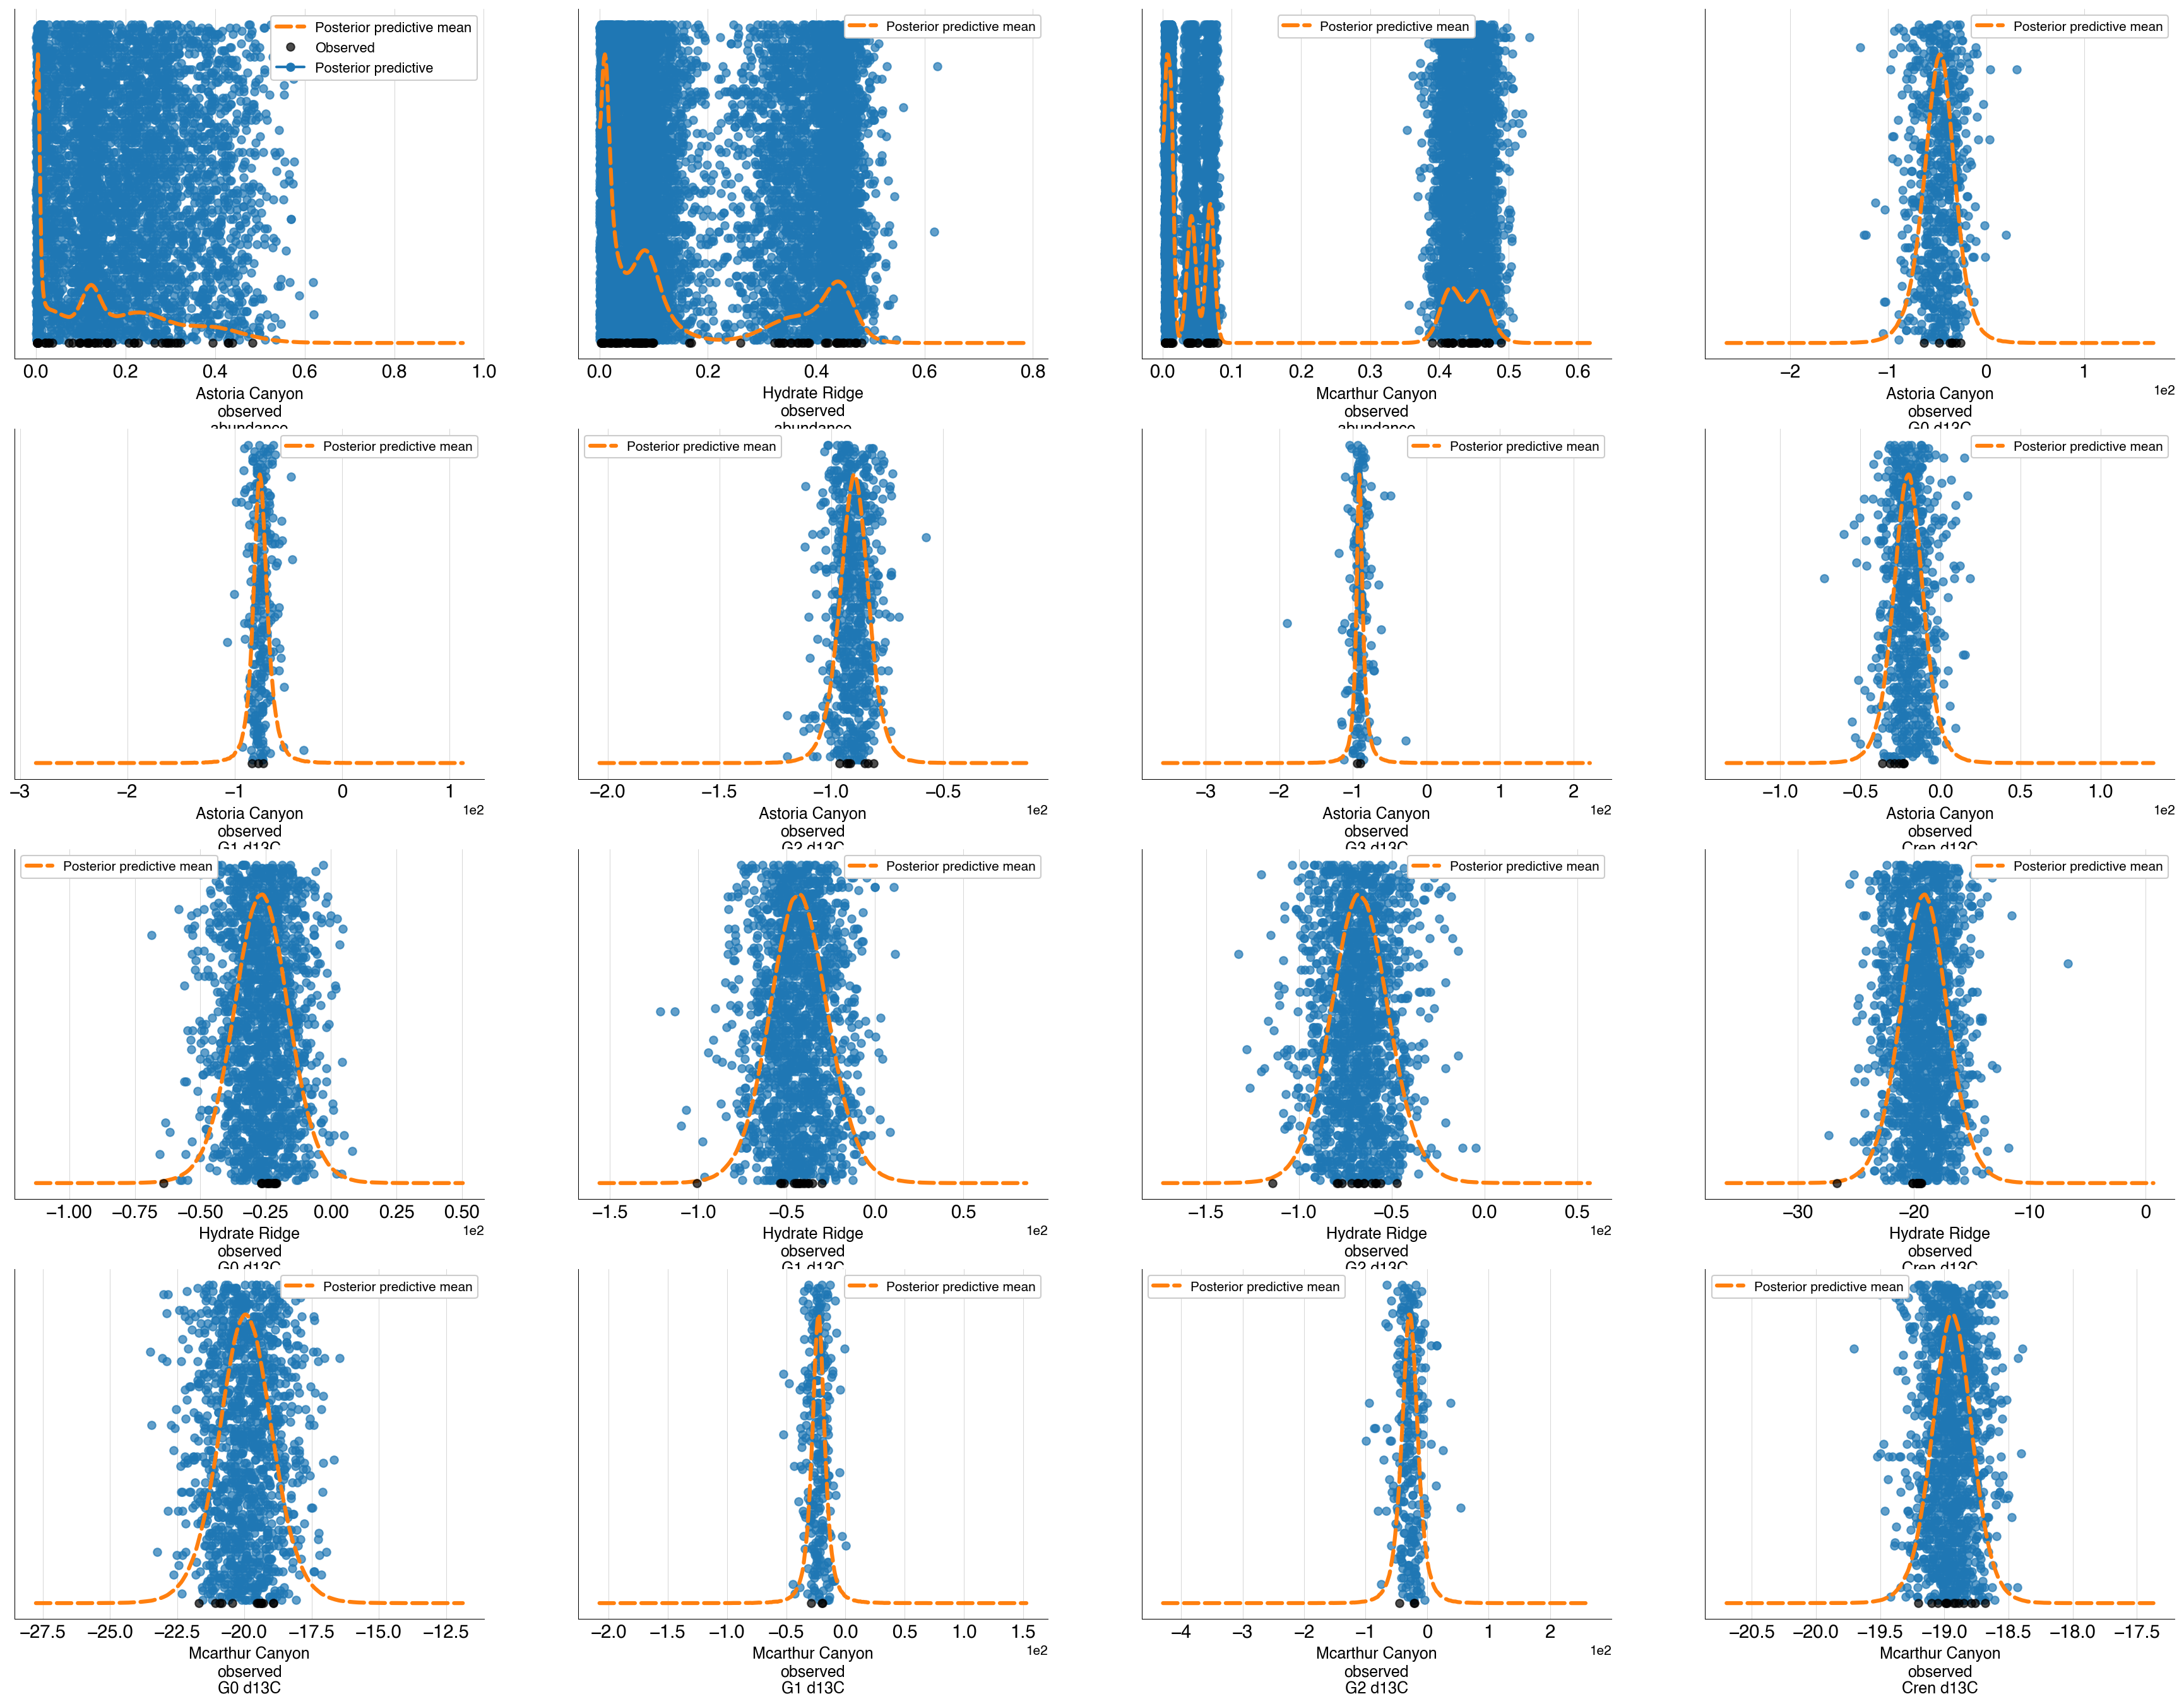

In [22]:
fig = plt.figure()
az.plot_ppc(ppc, num_pp_samples=100, kind="scatter")
fig.tight_layout()

### posterior summary & analysis

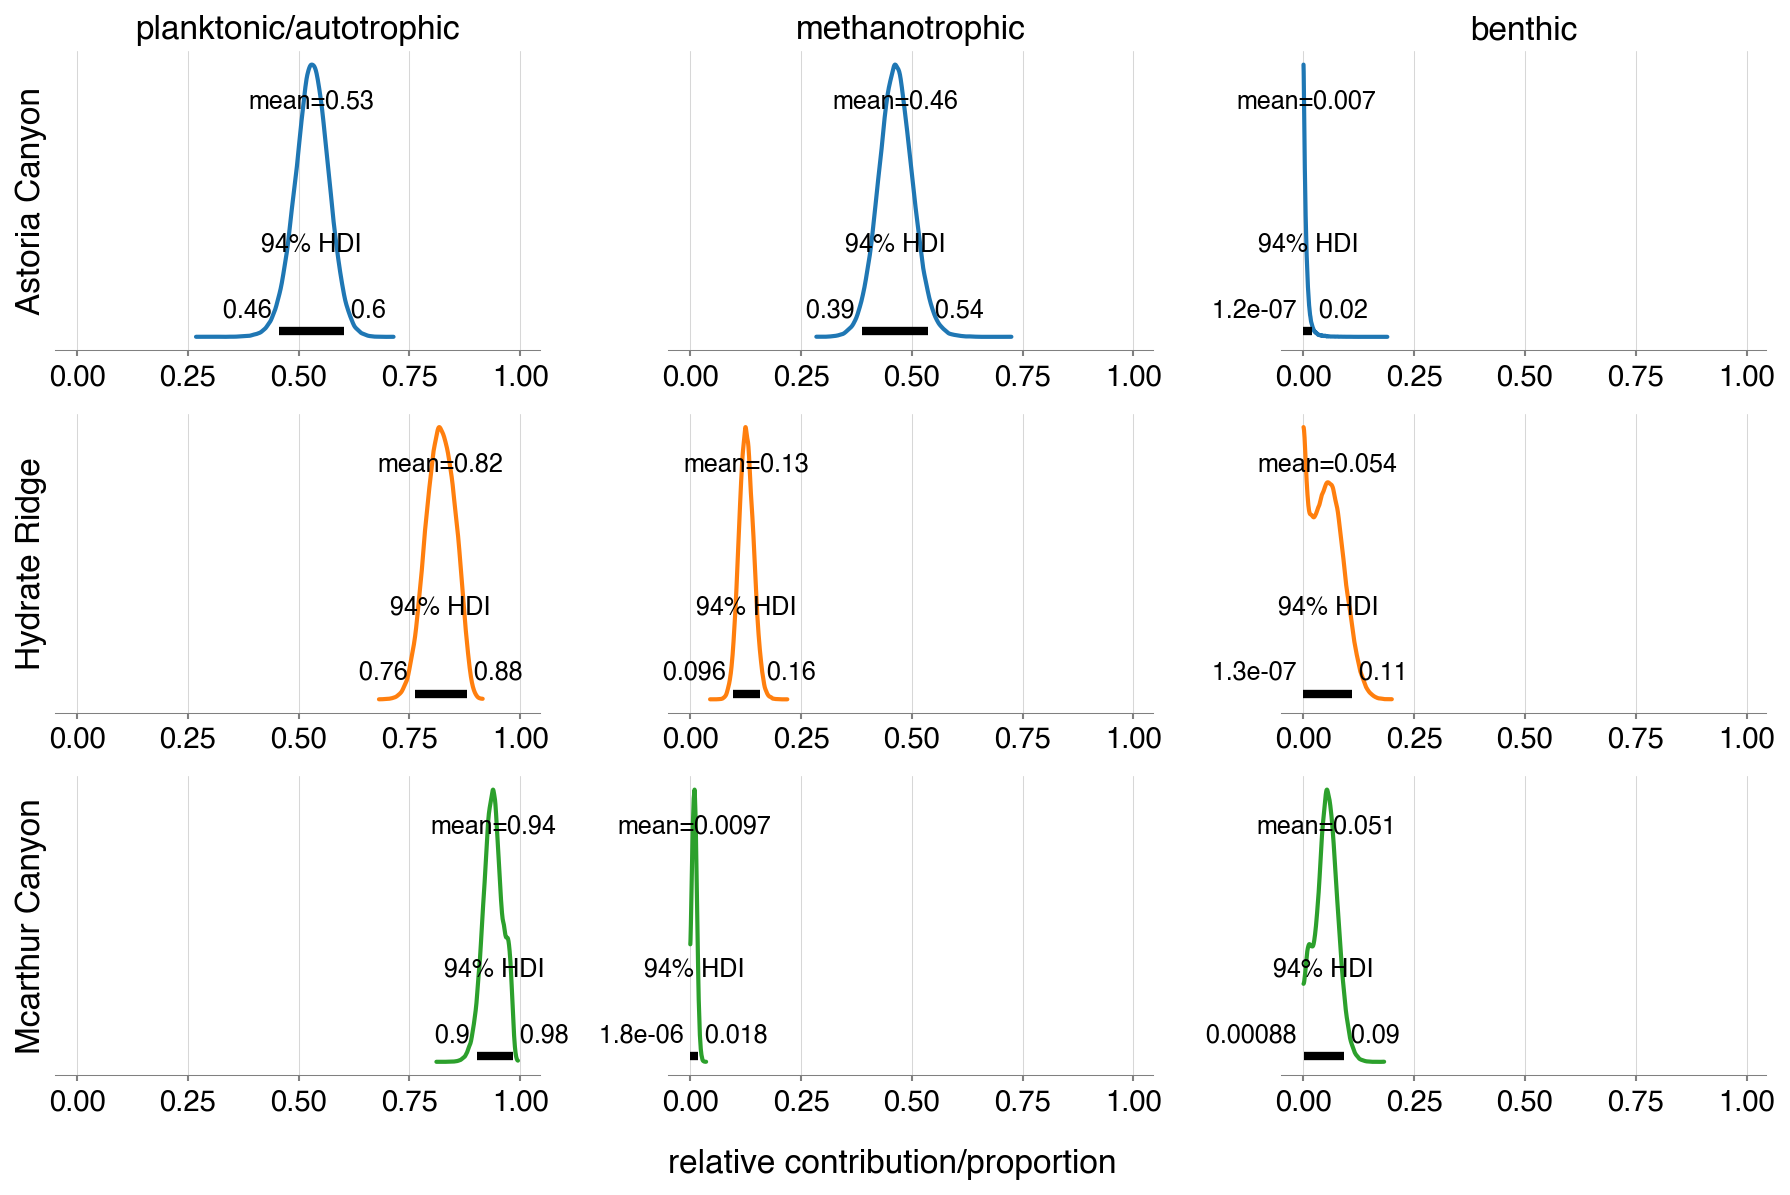

In [44]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8), sharex=True)
for i, location in enumerate(locations):
    axs[i, 0].set_ylabel(location, fontsize=16)
for j, com in enumerate(["planktonic/autotrophic", "methanotrophic", "benthic"]):
    for i in range(3):
        az.plot_posterior(post.posterior["F"][:, :, i, j], ax=axs[i, j], color=f"C{i}")
    axs[0, j].set_title(com, fontsize=16)
    for i in (1, 2):
        axs[i, j].set_title(None)
fig.supxlabel("relative contribution/proportion", fontsize=16)
fig.tight_layout()

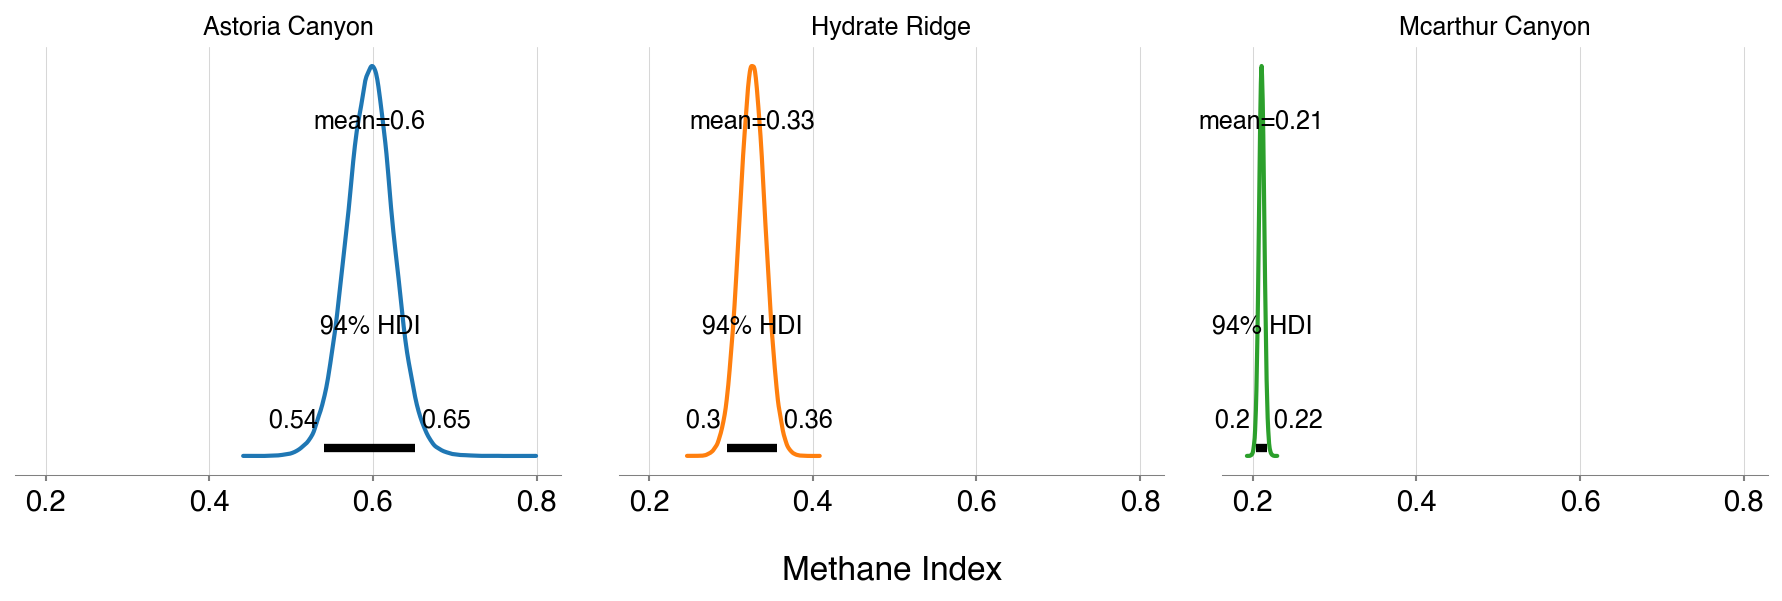

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
for i, ax in enumerate(axs):
    az.plot_posterior(post.posterior["Methane Index"][:, :, i], color=f"C{i}", ax=ax)
    ax.set_title(locations[i])
fig.supxlabel("Methane Index", fontsize=16)
fig.tight_layout()

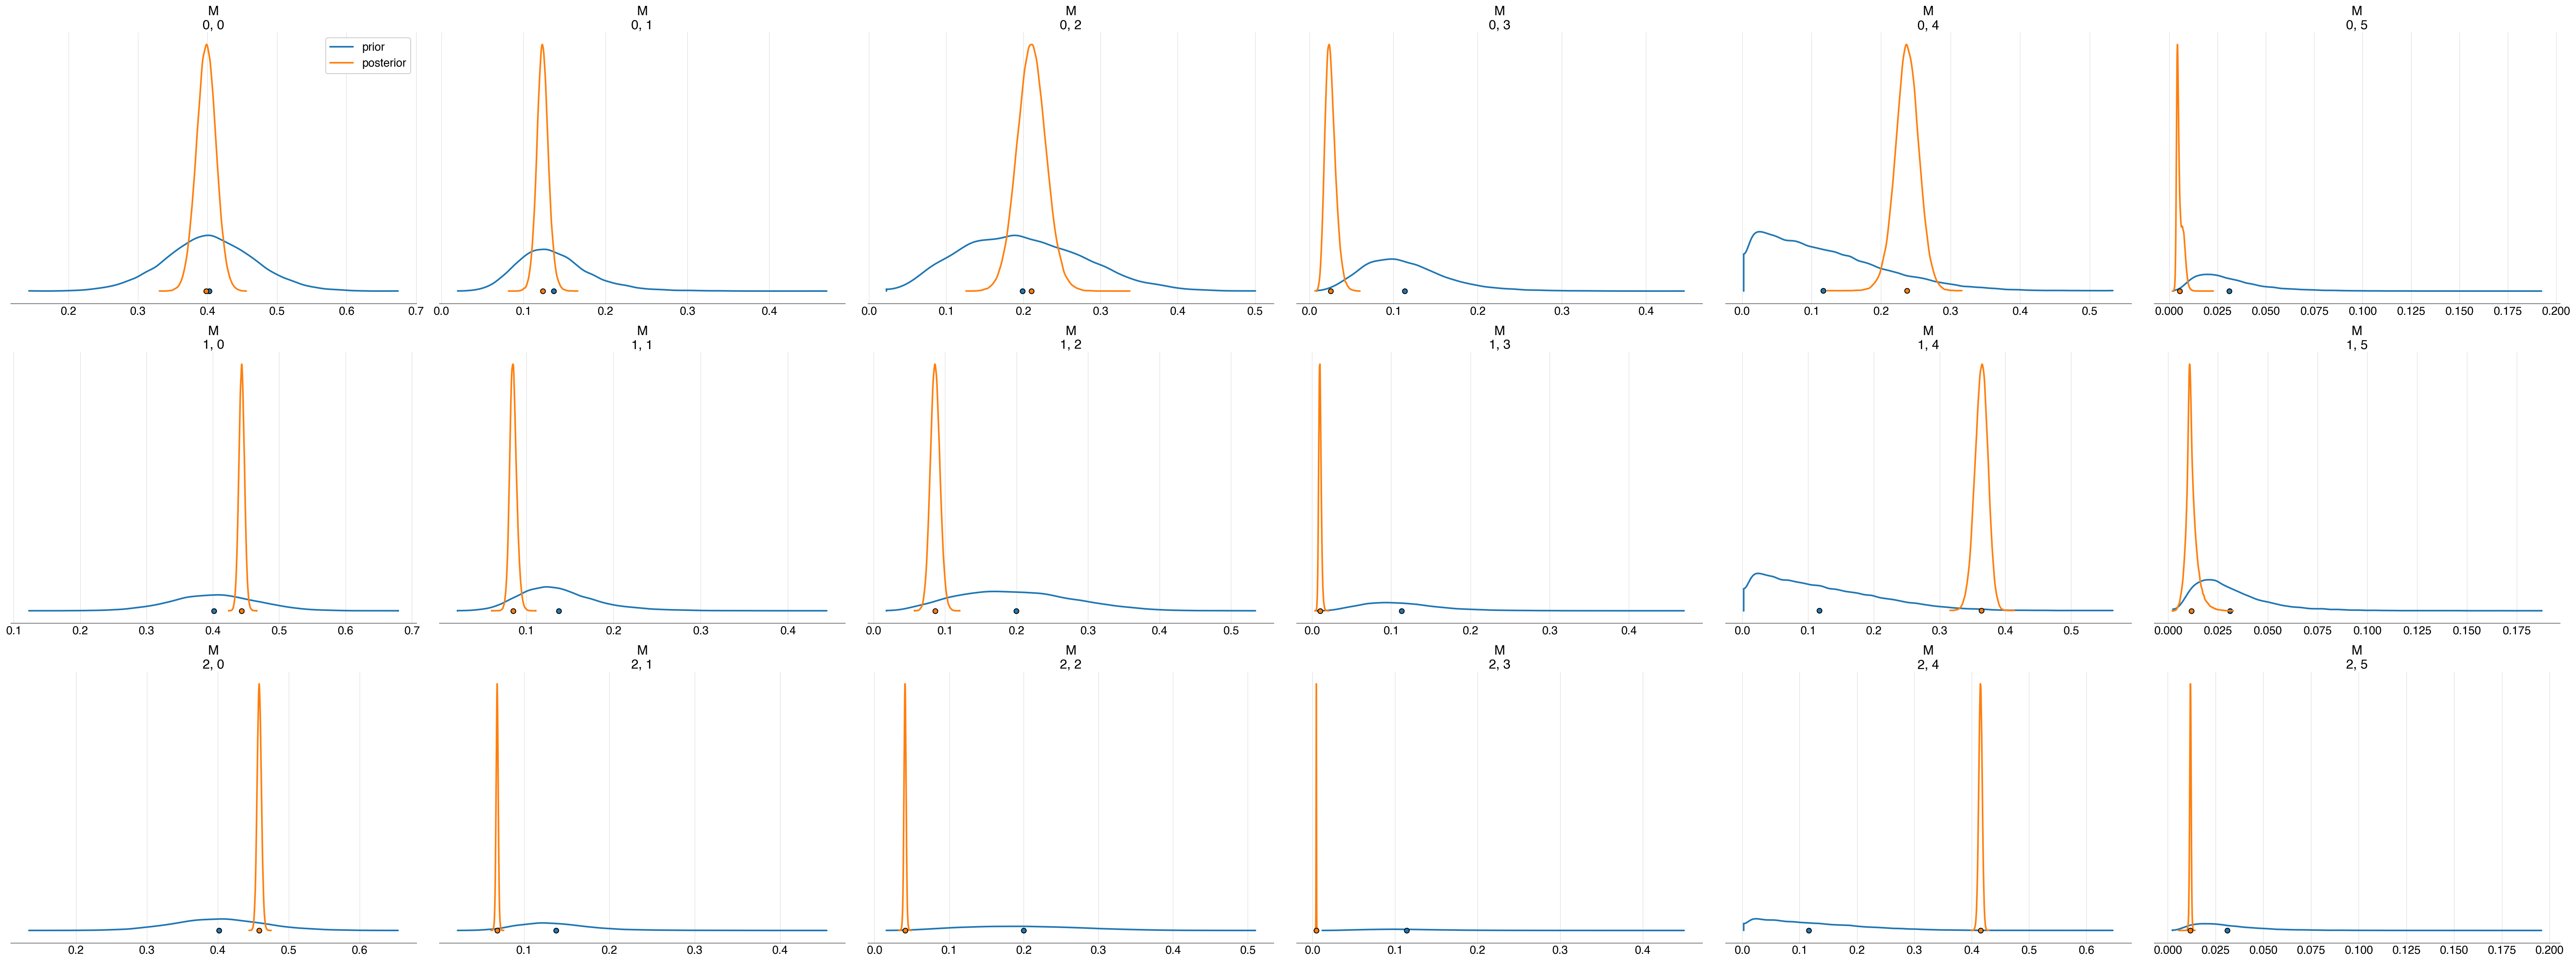

In [32]:
az.plot_density(
    [prior.prior, post.posterior],
    var_names=["M"],
    data_labels=["prior", "posterior"],
    hdi_prob=1,
    grid=(3, 6),
)
plt.gcf().tight_layout()

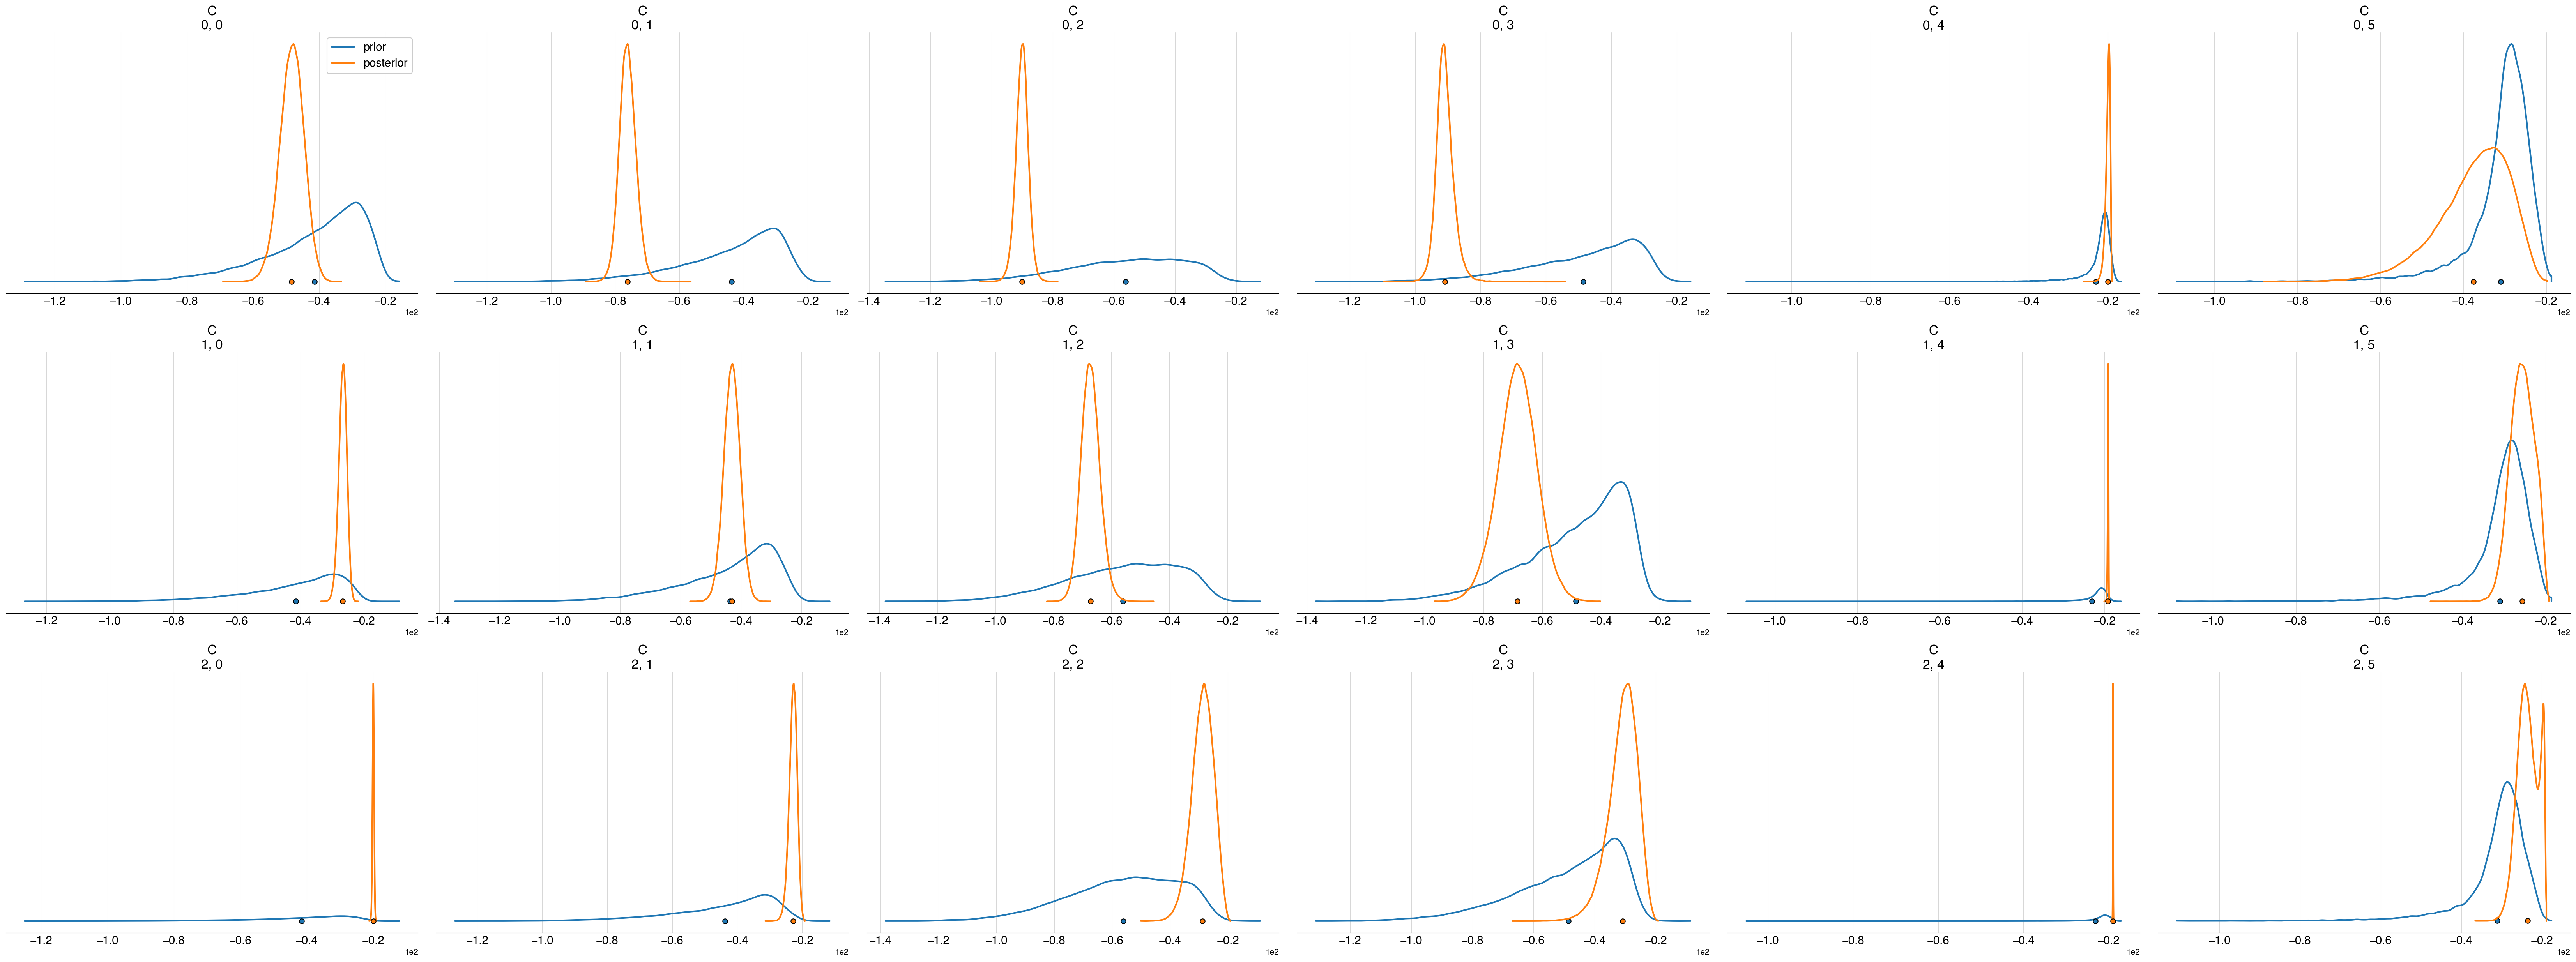

In [33]:
az.plot_density(
    [prior.prior, post.posterior],
    var_names=["C"],
    data_labels=["prior", "posterior"],
    hdi_prob=1,
    grid=(3, 6),
)
plt.gcf().tight_layout()

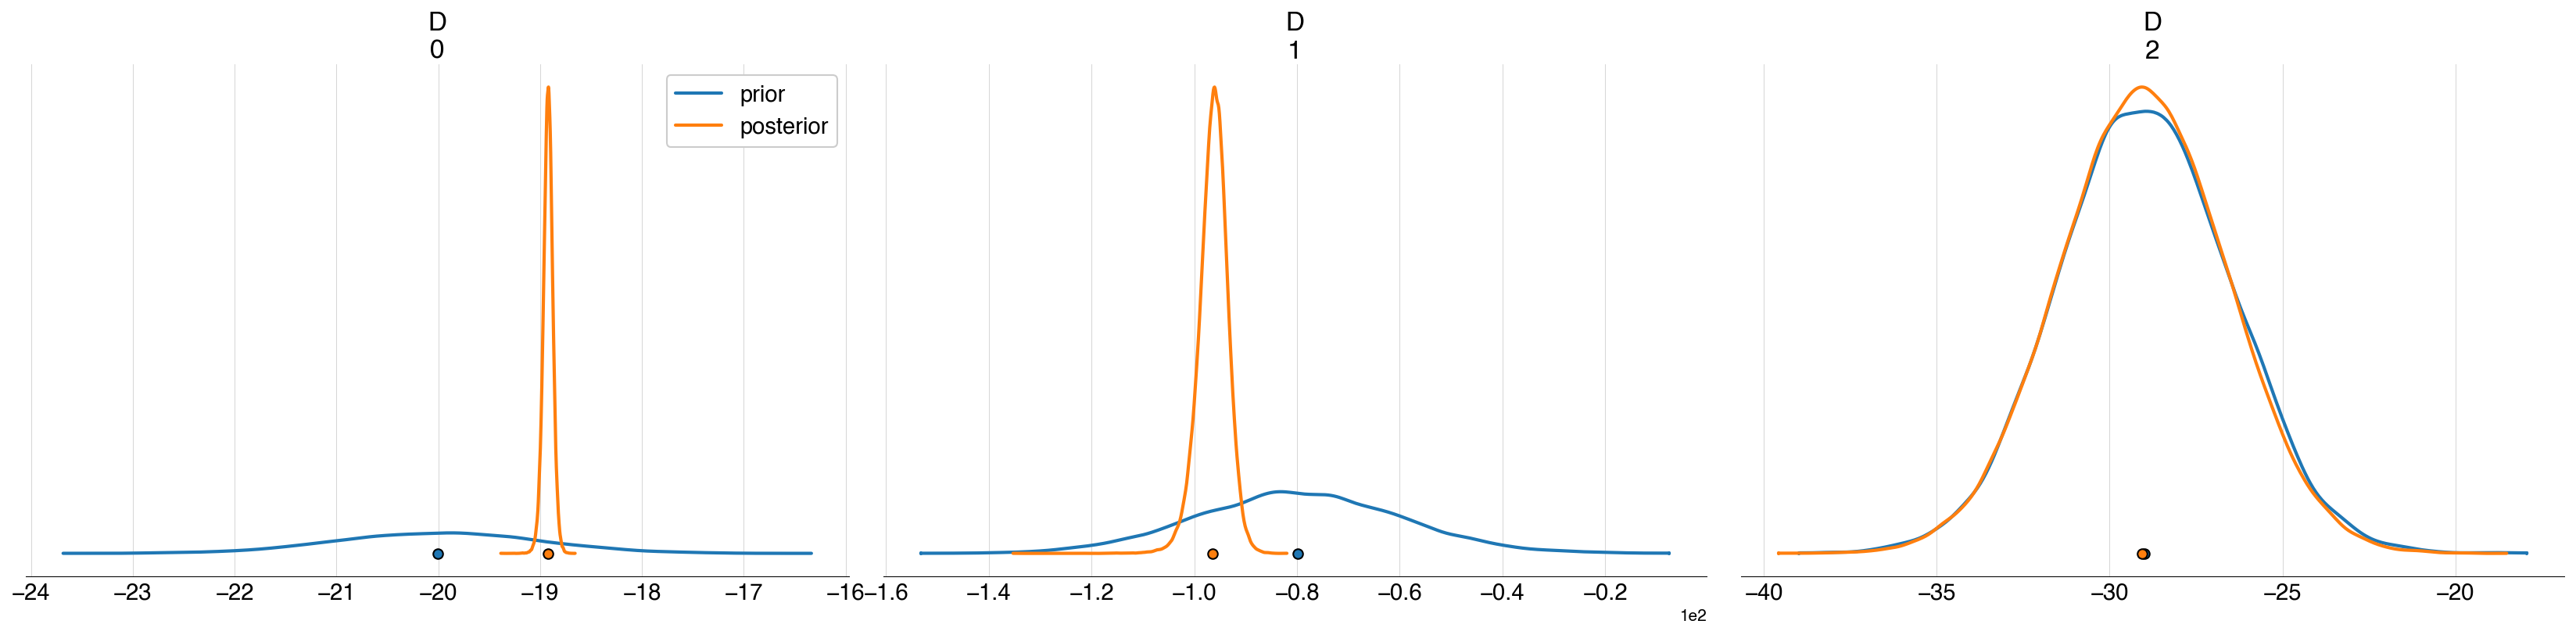

In [41]:
az.plot_density(
    [prior.prior, post.posterior],
    var_names=["D"],
    data_labels=["prior", "posterior"],
    hdi_prob=1,
)
plt.gcf().tight_layout()

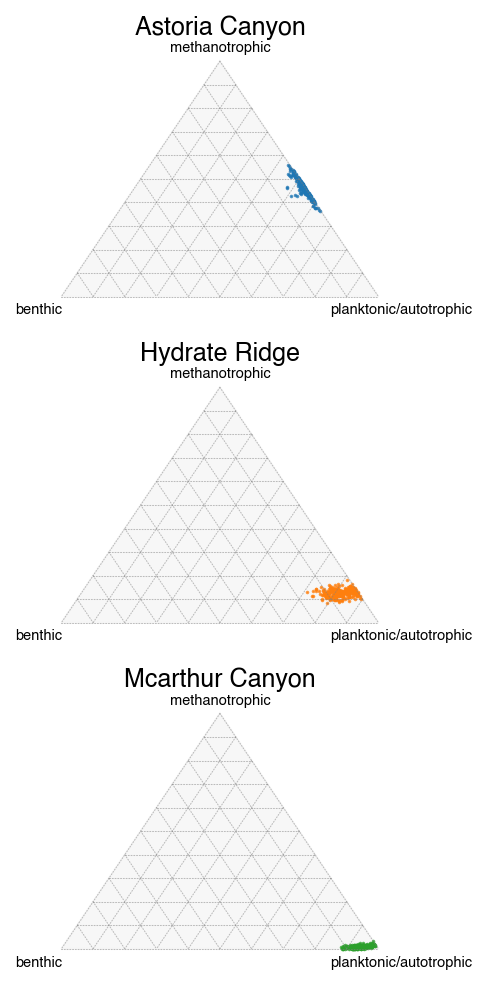

In [28]:
figure, axs = plt.subplots(3, 1, figsize=(3, 8))
for i, location in enumerate(locations):
    ax = axs[i]
    tax = ternary.TernaryAxesSubplot(ax=axs[i])
    ax.axis("off")
    tax.gridlines(color="grey", alpha=0.5, multiple=0.1)
    ax.set_xlabel(location)
    tax.right_corner_label("planktonic/autotrophic", fontsize=7)
    tax.top_corner_label("methanotrophic", fontsize=7, va="top")
    tax.left_corner_label("benthic", fontsize=7)
    tax.set_title(location, va="bottom")
    tax.scatter(
        (post.posterior["F"].values[j % 4, j, i, :] for j in range(250)),
        s=0.5,
        alpha=0.75,
        c=f"C{i}",
    )
    ax.annotate(location, (0, 1))
fig.tight_layout()